In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
import maha
import concurrent.futures

In [ ]:
# Leer csv
df = pd.read_csv('..\..\QM9\out.csv')

# Eliminar primeras 3 entradas
df = df.drop(df.index[0:3])
df = df.reset_index(drop=True)
df['Unnamed: 0'] = df['Unnamed: 0'] - 3

print(df.head())
print(len(df))

properties = pd.read_csv('gdb9.sdf.csv')

# Crear diccionario con propiedades usando mol_id como key
prop_dict = {}
for i in range(len(properties)):
    prop_dict[properties['mol_id'][i]] = properties.iloc[i, 1:]


   Unnamed: 0     ID Smiles  mol2vec-000  mol2vec-001  mol2vec-002  \
0           0  gdb_4    C#C     0.860594     0.857535    -0.138886   
1           1  gdb_5    C#N     0.830956     0.633586     0.085780   
2           2  gdb_6    C=O    -0.026393     0.148952    -0.367586   
3           3  gdb_7     CC    -0.215621    -0.162821    -0.220904   
4           4  gdb_8     CO    -0.247122    -0.112683    -0.157027   

   mol2vec-003  mol2vec-004  mol2vec-005  mol2vec-006  ...  mol2vec-290  \
0    -0.000812     0.209084     0.104682    -0.254994  ...    -0.692767   
1     0.152495     0.265132    -0.044169    -0.215196  ...    -0.424846   
2     0.606861     0.115350    -0.724784     0.062841  ...     0.197353   
3     0.340415    -0.267999    -0.357711     0.383969  ...     0.565001   
4     0.365515    -0.103020    -0.281875     0.418700  ...     0.122669   

   mol2vec-291  mol2vec-292  mol2vec-293  mol2vec-294  mol2vec-295  \
0     0.704518    -0.538793    -0.146952     0.082121     

In [4]:
#Mahalanobis
def distancia_mahalanobis(x, y, VI):
    delta = x - y
    maha_dists = np.sqrt(np.einsum('ni,ij,nj->n', delta, VI, delta))
    return maha_dists

vectors = df.iloc[:, 3:]
matrix = vectors.to_numpy()
print(matrix.shape)

cov_matrix = maha.cov_standard(matrix)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
diag_matrix = np.diag(eigenvalues)
VI = np.linalg.inv(diag_matrix)

(133244, 300)


In [17]:
data_size = 10000
# Elegir 1332 moleculas aleatorias
distancias_reduced = df.sample(n=data_size, random_state=42)
# Elegir las primeras 1332 moleculas
#distancias_reduced = df.head(data_size)
distancias_reduced = distancias_reduced.reset_index(drop=True)
print(distancias_reduced.head())
print(len(distancias_reduced))

# Calcular distancias
matrix = distancias_reduced.iloc[:, 3:]
matrix = matrix.to_numpy()
print(matrix.shape)

   Unnamed: 0          ID                          Smiles  mol2vec-000  \
0      133561  gdb_133565  FC(F)(F)[C@H]1[C@H]2C[C@@H]1C2    -1.052154   
1       35558   gdb_35562         N#C[C@H]1N[C@H]2CCC=C21     0.630165   
2       61921   gdb_61925          C#CCO[C@H](C)[C@H]1CO1     1.149173   
3      119572  gdb_119576        COC[C@]12C[C@H]1C[C@H]2C    -0.009128   
4       84676   gdb_84680       C[C@]12CC[C@H]1C=C[C@H]2O    -0.054362   

   mol2vec-001  mol2vec-002  mol2vec-003  mol2vec-004  mol2vec-005  \
0     1.643396     3.623622     4.765460    -3.886410     0.053925   
1     2.296809    -0.081331     0.323852     0.795538    -4.295306   
2     3.703401     1.250479     1.107942    -1.418481    -0.280243   
3     2.960706     0.052341     2.309084    -0.737710    -0.419438   
4     1.781020     1.312528     1.350384    -2.297145    -1.896243   

   mol2vec-006  ...  mol2vec-290  mol2vec-291  mol2vec-292  mol2vec-293  \
0     1.499430  ...    -0.399972     0.904785    -0.055262 

In [5]:
# Function to compute a single row of the distance matrix
def compute_row(i, matrix, VI):
    return distancia_mahalanobis(matrix, matrix[i], VI)

# Initialize distance matrix
distance_matrix = np.zeros((len(matrix), len(matrix)))

# Use ThreadPoolExecutor to compute rows in parallel
with concurrent.futures.ThreadPoolExecutor(max_workers=32) as executor:
    # Submit all tasks
    futures = {executor.submit(compute_row, i, matrix, VI): i for i in range(len(matrix))}
    # Collect results as they complete
    for future in concurrent.futures.as_completed(futures):
        print(f'Completed row {futures[future]}')
        i = futures[future]
        distance_matrix[i] = future.result()

# Update the 'distancias' DataFrame (adjust according to your needs)
distancias = distancias_reduced.copy()
# Example: Add each distance vector as a new column
for i in range(len(matrix)):
    distancias[f'distance_{i}'] = distance_matrix[:, i]

Completed row 3
Completed row 21
Completed row 15
Completed row 23
Completed row 12
Completed row 24
Completed row 17
Completed row 28
Completed row 13
Completed row 18
Completed row 1
Completed row 7
Completed row 0
Completed row 19
Completed row 30
Completed row 11
Completed row 4
Completed row 2
Completed row 5
Completed row 6
Completed row 16
Completed row 9
Completed row 25
Completed row 10
Completed row 26
Completed row 22
Completed row 20
Completed row 8
Completed row 27
Completed row 14
Completed row 32
Completed row 35
Completed row 36
Completed row 34
Completed row 37
Completed row 38
Completed row 41
Completed row 42
Completed row 33
Completed row 31
Completed row 39
Completed row 29
Completed row 43
Completed row 45
Completed row 40
Completed row 46
Completed row 44
Completed row 51
Completed row 54
Completed row 62
Completed row 63
Completed row 64
Completed row 67
Completed row 47
Completed row 68
Completed row 69
Completed row 66
Completed row 72
Completed row 71
Complet

C:\Users\locua\AppData\Local\Temp\ipykernel_14888\349936729.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  distancias[f'distance_{i}'] = distance_matrix[:, i]
C:\Users\locua\AppData\Local\Temp\ipykernel_14888\349936729.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  distancias[f'distance_{i}'] = distance_matrix[:, i]
C:\Users\locua\AppData\Local\Temp\ipykernel_14888\349936729.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perf

In [6]:
print(distancias.head())
print(distancias.shape)
# Guardar distancias en archivo
distancias.to_csv('distancias.csv')
print('Distancias guardadas en distancias.csv')

   Unnamed: 0          ID                                             Smiles  \
0       32354   gdb_32358                                COC1=COC([NH-])N=C1   
1      120168  gdb_120172                        OCC[C@H]1[N@H+]2C[C@]1(O)C2   
2       49412   gdb_49416           O=C[C@H]1[C@H]2C=C[C@@H]3[C@H]2[N@@H+]31   
3        9330    gdb_9334                                  [H]/N=C(\C=O)NCCO   
4       84205   gdb_84209  C[C@H]1[CH-][C@H]2[C@@H]3[C@@H]4[C@H]2[C@H]1[C...   

   mol2vec-000  mol2vec-001  mol2vec-002  mol2vec-003  mol2vec-004  \
0     2.664131     1.859251     0.207205     1.047353    -1.268736   
1     0.815812     2.823325    -0.849519     2.122603    -1.272046   
2     2.369028     1.822806     1.261998     2.345082    -0.535340   
3    -1.289170     0.037183     1.101825     3.687842    -3.966616   
4     1.952671     2.028325     1.669772     3.963110    -0.587116   

   mol2vec-005  mol2vec-006  ...  distance_9990  distance_9991  distance_9992  \
0    -2.677464   

In [3]:
# Cargar distancias
distancias = pd.read_csv('distancias.csv')

In [5]:
# Obtener el menor valor de distance_10
print(distancias['distance_100'].min())
print(distancias['distance_100'].idxmin())
print(distancias['distance_100'].nsmallest(5))
#print(distancias.head())
print(distancias.iloc[76])


0.0
100
100       0.000000
8564    134.740035
3025    169.403818
767     173.009888
1002    182.874345
Name: distance_100, dtype: float64
Unnamed: 0.1                   76
Unnamed: 0                  36728
ID                      gdb_36732
Smiles           C#CCO[C@H]1CCCO1
mol2vec-000             -0.138611
                       ...       
distance_9995          626.563421
distance_9996          602.477209
distance_9997          703.010351
distance_9998          832.278302
distance_9999          582.898751
Name: 76, Length: 10304, dtype: object


6285    c1cc2cc[nH]c2cn1
8094      Cc1cnc(=O)ncn1
Name: Smiles, dtype: object
8397
1055.5496107613417
480.64312900198144


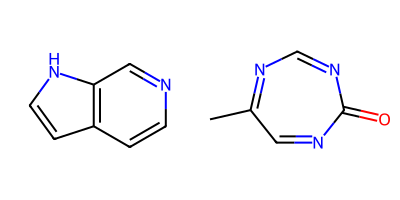

In [9]:
# Probar con un par de moleculas

# Obtener 2 moleculas aleatorias
moleculas = distancias.sample(n=2)
# Obtener las primeras 2 moleculas
#moleculas = distancias.iloc[100]
#moleculas_2 = distancias.iloc[431]
#moleculas = pd.concat([moleculas, moleculas_2], axis=1)
#moleculas = moleculas.T


print(moleculas['Smiles'])  

# Imprimir distancias
print(moleculas.index[1] + 303)
print(distancias.iloc[moleculas.index[0], moleculas.index[1] + 303])
print(distancias['distance_' + str(moleculas.index[1])][moleculas.index[0]])

mol_1 = Chem.MolFromSmiles(moleculas['Smiles'][moleculas.index[0]])
mol_2 = Chem.MolFromSmiles(moleculas['Smiles'][moleculas.index[1]])

# Graficar
Chem.Draw.MolsToGridImage([mol_1, mol_2], molsPerRow=2, subImgSize=(200, 200))

7774
770.3350650680516
1077.2045952797218
C#CC1CCOCC1


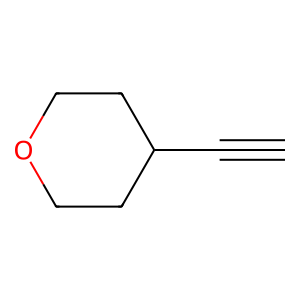

In [ ]:
# Elegir un elemento aleatorio
elemento = np.random.randint(0, data_size)
print(elemento)
print(distancias.iloc[moleculas.index[0], elemento + 303])
print(distancias['distance_' + str(elemento)][moleculas.index[0]])
elemento = distancias.iloc[elemento]
print(elemento['Smiles'])
mol_3 = Chem.MolFromSmiles(elemento['Smiles'])
Chem.Draw.MolToImage(mol_3)

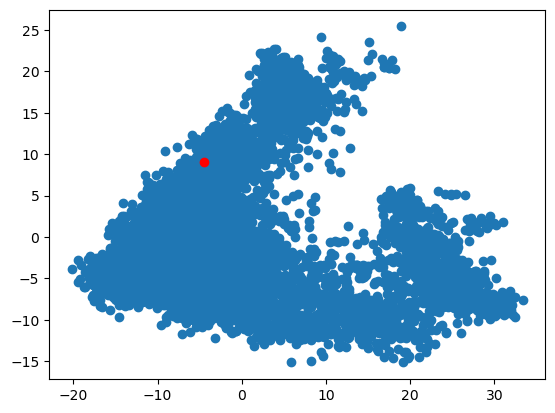

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(matrix)
matrix_pca = pca.transform(matrix)

plt.scatter(matrix_pca[:, 0], matrix_pca[:, 1])
plt.scatter(matrix_pca[elemento.name, 0], matrix_pca[elemento.name, 1], color='red')
#plt.scatter(matrix_pca[moleculas.index[0], 0], matrix_pca[moleculas.index[0], 1], color='green')

plt.show()


In [ ]:
# Obtener distancia entre gaps
gap_target = prop_dict[elemento['ID']]['gap']
print(gap_target)

# Resta de gap_target con cada gap
gap_dic = {}
gap_gradient = []
for i in range(data_size):
    delta = abs(gap_target - prop_dict[distancias.iloc[i]['ID']]['gap'])
    gap_gradient.append(delta)
    gap_dic[distancias['ID'][i]] = delta

0.3061


C#CC1CCOCC1
7774
990.6256909424905
10000


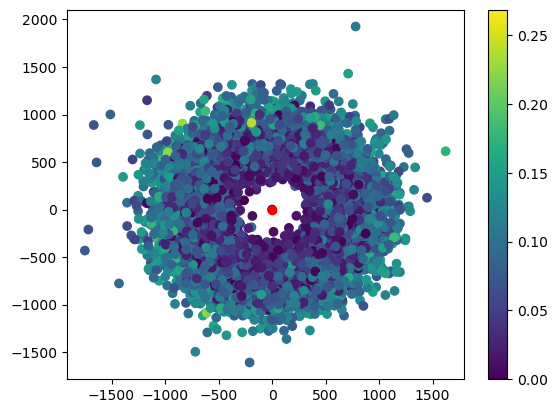

In [ ]:
# Usar distancias

centro = elemento
print(centro['Smiles'])
print(centro.name)
print(distancias.iloc[centro.name, centro.name + 303])

# Usar distancia

angles = np.random.uniform(0, 2*np.pi, data_size)
dists = distancias.iloc[centro.name, 304:]
print(len(dists))

x = dists * np.cos(angles)
y = dists * np.sin(angles)

# Color basado en gap_gradient
plt.scatter(x, y, c=gap_gradient, cmap='viridis')
plt.colorbar()
plt.scatter(0, 0, color='red')
plt.show()


[('gdb_95805', 0.0), ('gdb_64229', 0.0), ('gdb_38623', 0.0), ('gdb_14913', 0.0), ('gdb_39978', 0.0), ('gdb_83431', 9.999999999998899e-05), ('gdb_104739', 9.999999999998899e-05), ('gdb_15576', 0.0001000000000000445), ('gdb_91959', 0.0001000000000000445), ('gdb_66853', 0.0001000000000000445), ('gdb_78524', 0.0001000000000000445), ('gdb_17826', 0.00019999999999997797), ('gdb_105060', 0.00020000000000003348), ('gdb_114048', 0.00020000000000003348), ('gdb_77667', 0.00020000000000003348), ('gdb_12148', 0.00020000000000003348), ('gdb_81024', 0.00020000000000003348), ('gdb_81070', 0.00020000000000003348), ('gdb_105251', 0.00020000000000003348), ('gdb_19554', 0.00029999999999996696), ('gdb_123022', 0.00029999999999996696), ('gdb_63518', 0.00029999999999996696), ('gdb_66778', 0.00030000000000002247), ('gdb_64118', 0.00030000000000002247), ('gdb_59708', 0.00030000000000002247), ('gdb_107763', 0.00030000000000002247), ('gdb_120052', 0.00030000000000002247), ('gdb_101168', 0.00039999999999995595), 

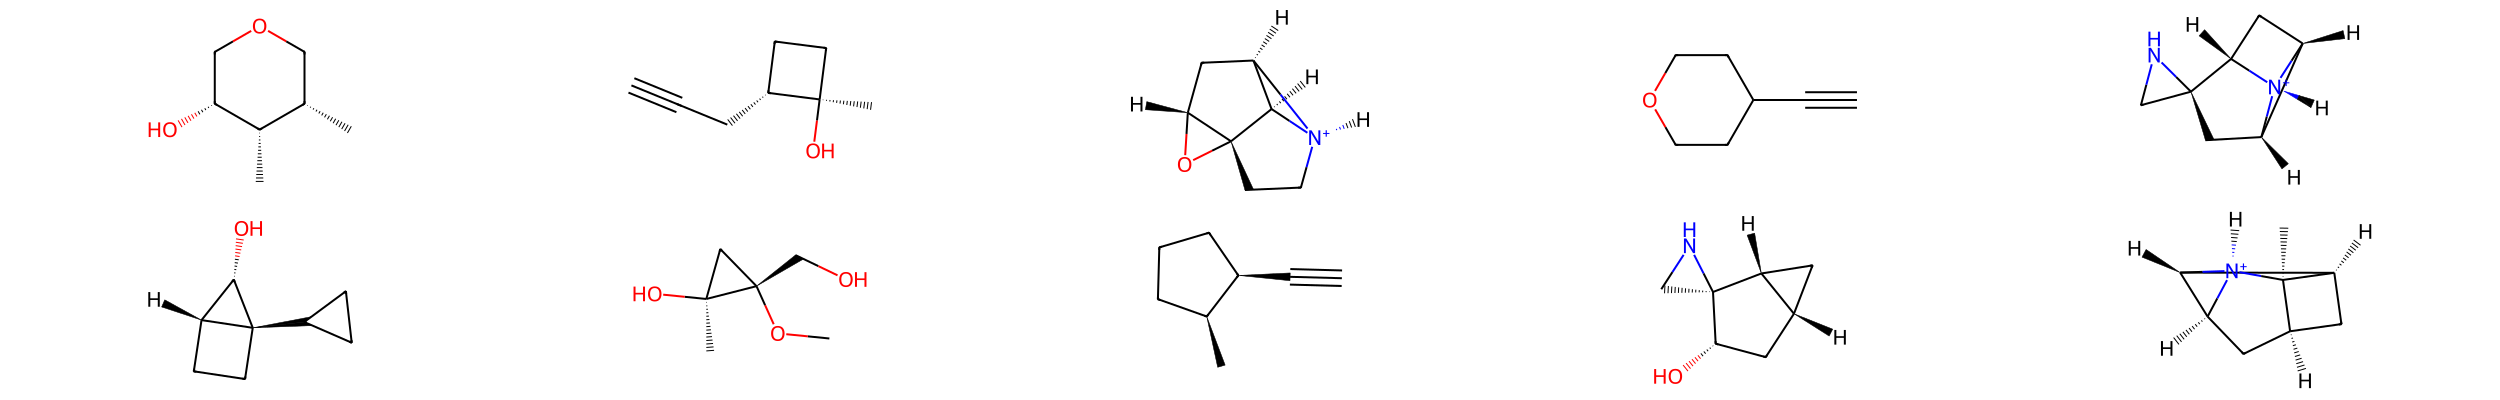

In [67]:
# Dibujar mejor gap

best = sorted(gap_dic.items(), key=lambda x: x[1])
print(best)

smiles = []
# Get SMILES
for i in range(10):
    #print(best[i][0])
    #smiles.append(distancias['Smiles'].loc[distancias['ID'] == best[i][0]])
    smiles.append(distancias['Smiles'][distancias['ID'] == best[i][0]])

chems = []
for smile in smiles:
    print(smile.iloc[0])
    chems.append(Chem.MolFromSmiles(smile.iloc[0]))


Chem.Draw.MolsToGridImage(chems, molsPerRow=5, subImgSize=(500, 200))
